# Project 2  Bipartite Network

## By Team VC

### Abstract

This projects demonstrates using the Networkx library to analyze bipartite networks. Starting from a dataset connecting US states to a set of legal reasons for divorce, hiearchical clustering shows how different states form a clique of based around the common causes of 'incompatibility' and 'alcoholism.' 

This project also shows why island clustering was not successful as all subgraphs were fully connected despite varying a weight threshold.

### Introduction

Let's explore a bipartite network, or commonly referred as a two mode network. First, a bipartite network is one where there are at least two types of nodes where their connections are based on the primary node connection. In short, nodes of one set can only be transverse if they share the same connection to a node of the other set. 

We selected [Pajek's Divorce Network](http://vlado.fmf.uni-lj.si/pub/networks/data/2mode/divorce.net) for our analysis. For some background, Pajek's divorce network is made up state node set and a reason node set. The state nodes are comprise of the US's 50 states and the law nodes are the divorce laws supported based on the reasons for seperation. Their connection represents if the US state has a the specific divorce law in placed based on the reason of separation. In order to use this dataset, we pre-processed it from the .net file into a .edgelist viewed [here](https://github.com/Vy4thewin/Data620_TeamVAC/blob/main/generate_edgelist.py). After the .edgelist transformation, we imported the 2 mode network with the bipartite function. Let's view how the network looks below!

### Visualization

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from networkx.algorithms import bipartite

#Loading in the divorce network
divorce=bipartite.read_edgelist("divorce.edgelist",delimiter=",",nodetype=str)

#Seperating the two node sets into their groupings
states, causes = bipartite.sets(divorce)

#Lets check that the two sets were seperated correctly
list(states)
list(causes)

['nonsupp',
 'impotenc',
 'alcohol',
 'insanity',
 'cruelty',
 'separate',
 'desertn',
 'incompat',
 'felony']

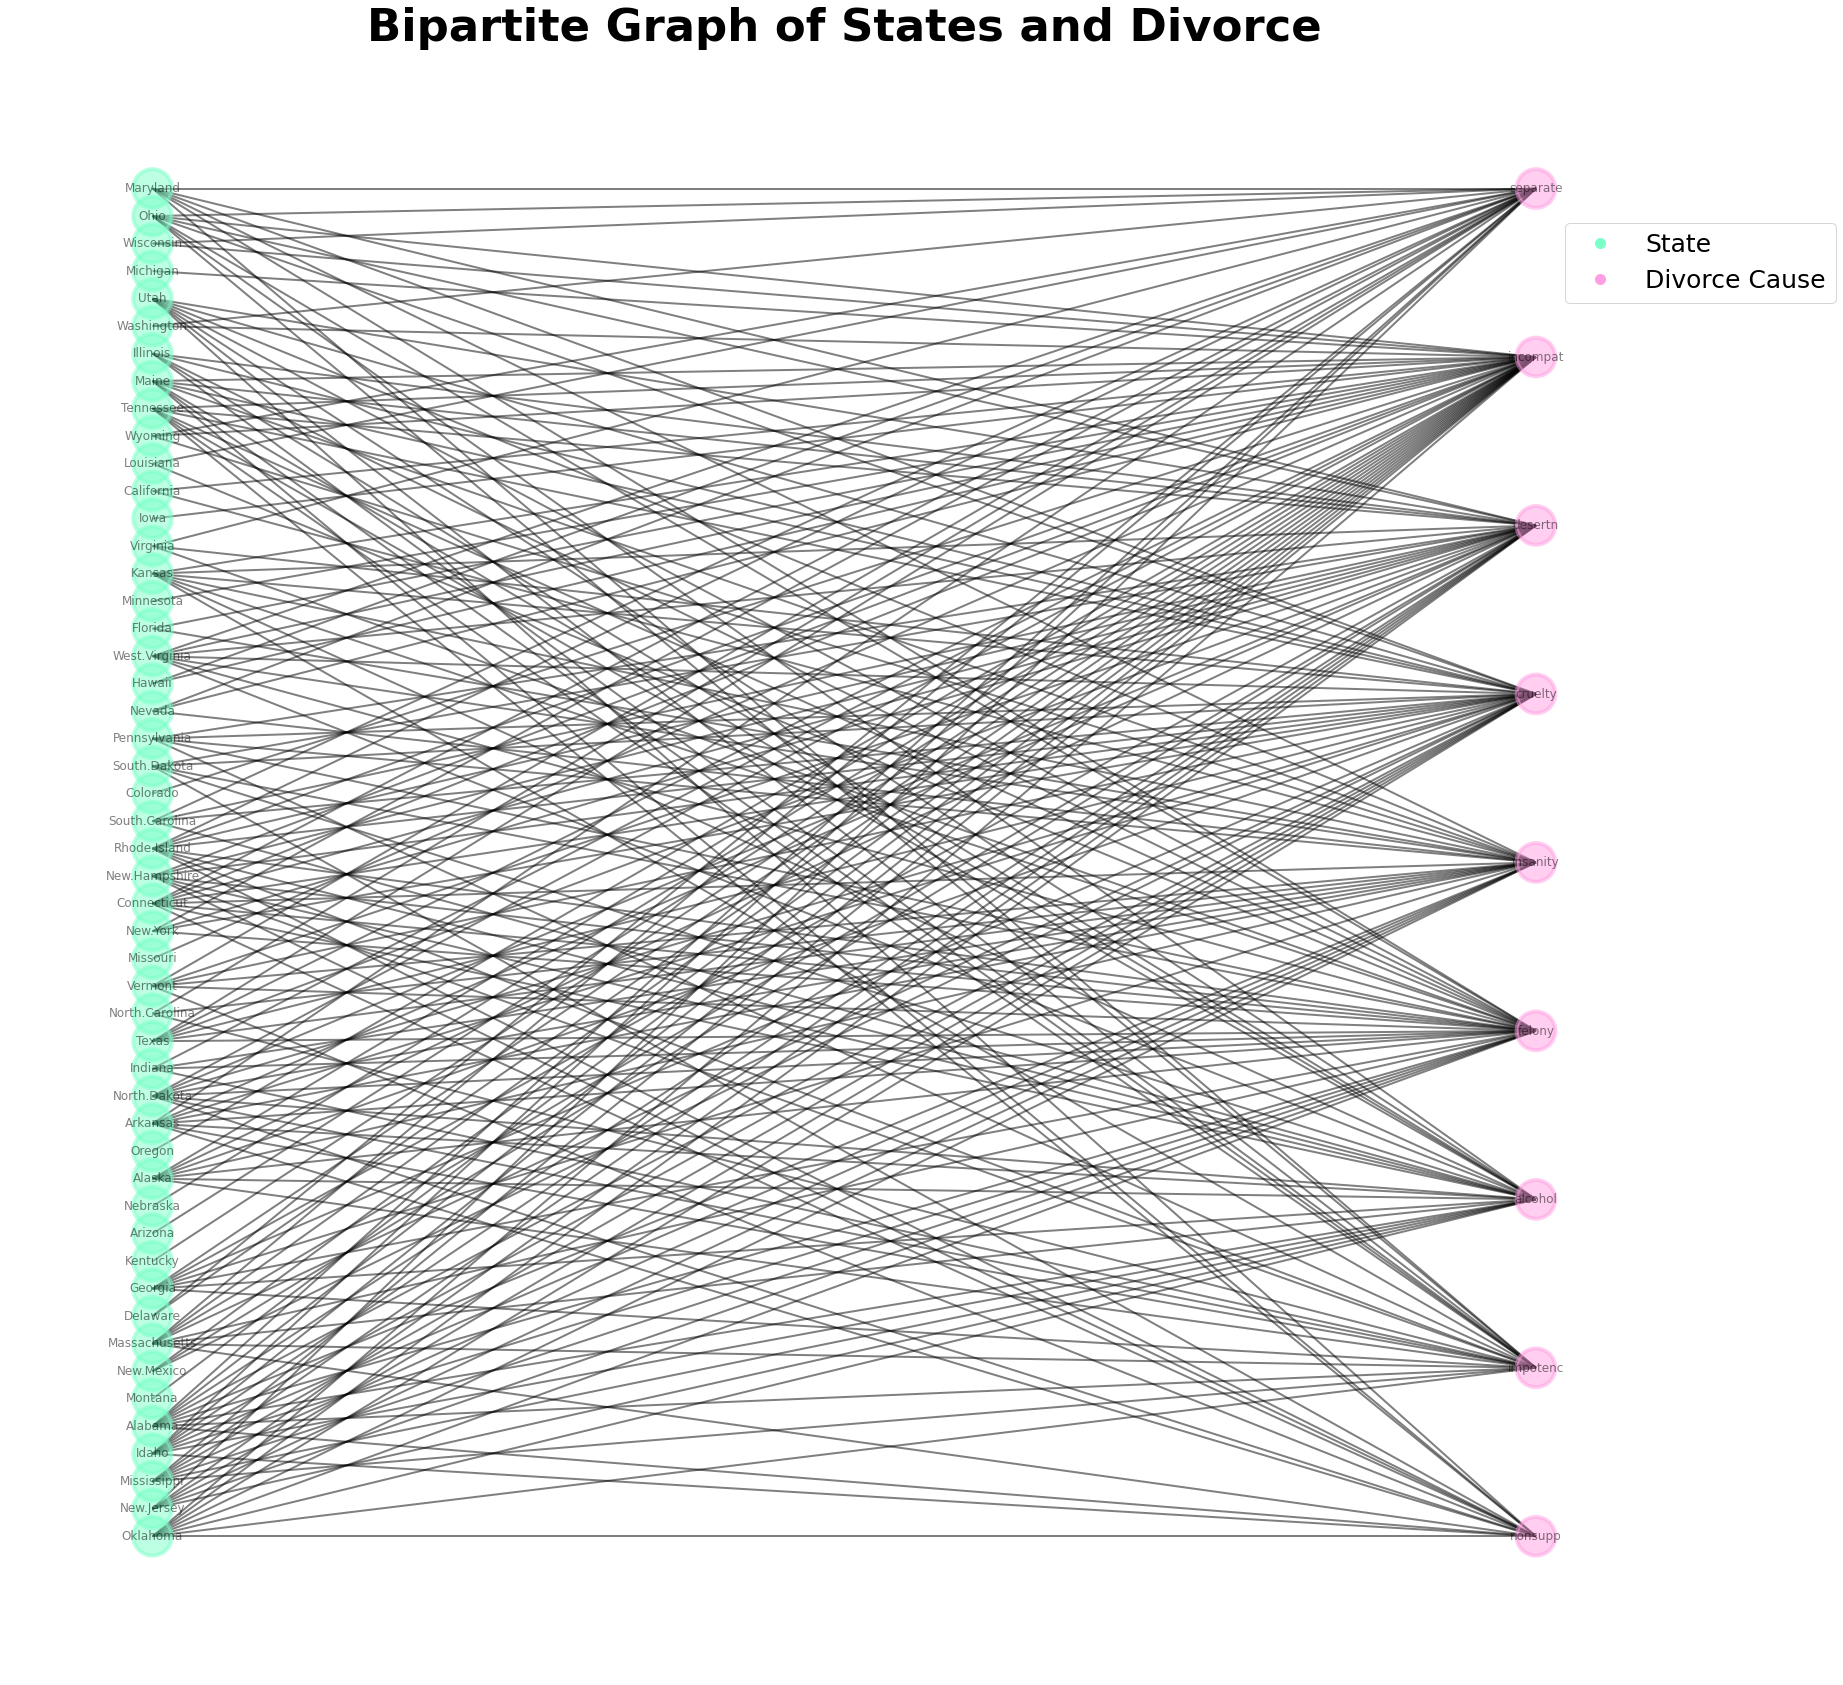

In [2]:
#Lets see what the system grabbed as the node set for reference
values=bipartite.color(divorce)

#States received set 1 and legal causes were set 2
nodes_family={0:'#7affc8',1:'#ff9ee2'}
nodes_colors=[nodes_family[i[1]] for i in divorce.nodes.data('bipartite')]

# Plot options
plt.figure(figsize=(30, 30))
plt.title("Bipartite Graph of States and Divorce", fontdict= { 'fontsize': 45, 'fontweight':'bold'}, loc='center')
colors = ['#7affc8','#ff9ee2']
texts = ['State', 'Divorce Cause']

patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(
           handles=patches, 
           ncol=1, 
           numpoints=1, 
           fontsize = 25, 
           loc="upper right",
           bbox_to_anchor=(1.1, 0.9)
          )


#Lets create a visual of the network
pos=nx.bipartite_layout(divorce,states)
nx.draw(divorce,with_labels=True,node_size=1500,node_shape="o" ,alpha=0.5 ,linewidths=4, width=2,node_color=nodes_colors,pos=pos)
plt.show()


### Limiting Down the Network Scope


#### Previous scope limitation

##### Attempt at Island Clustering

We also attempted to use the island-clustering method without success. As the weight threshold was varied from 1 to 8, all of the graphs were completely connected.

In [12]:
#Code derived from Chapter 4 from SNAFS
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            #print(edata['weight'])
            g2.add_edge(f, to, weight=edata['weight'])
    return g2


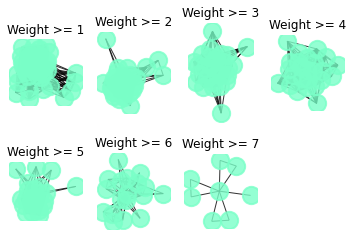

In [21]:
projected_states = bipartite.weighted_projected_graph(divorce, list(states))

#plt.figure(figsize=(15, 15))
#ax.set_aspect('equal')

for i in range(1,8):
    ax=plt.subplot(2,4,i)
    title = "Weight >= {0}".format(i)
    plt.title(title)
    ax.set_aspect('equal')
    trimmed = trim_edges(projected_states, i)
    nx.draw(trimmed, alpha=0.8 ,linewidths=2, width=1,node_color='#7affc8')
    
plt.show()

Regardless of the weight threshold, there is only one fully connected island that appears. Therefore, island clustering is not a feasible method for analysis for this dataset.

#### Current network reduction 

From our original pull, the network has a lot of connections and will make it difficult to see most common legal cause for a separation. In order to narrow our scope, we decided to choose the most connected cause of the graph.

We can see below the first strongest cause based on its centrality degree is incompatibility. Let's create a subgraph to see the edges formed by the incompatibility cause in divorce; we can use the Networkx.ego_graph() function to reduce the original network for connections to the incompatability node. For our distance of the graph, we can see the scope for all connections with a radius of three away from the base node for a view on clusters.

In [ ]:
#Let's find out the most connected node of the graph
causes_cent=sorted(nx.bipartite.degree_centrality(divorce,causes).items() , key=lambda x: x[1], reverse=True)
print ("Most common cause for divorce:")
print(causes_cent[18])


In [ ]:
plt.figure(figsize=(20, 20))
plt.title("Incompatibility-Centered Network with Radius = 3", fontdict= { 'fontsize': 33, 'fontweight':'bold'}, loc='center')


#Create a filtered for only connections three away from incompatibiity 
incomp_G=nx.ego_graph(divorce, 'incompat', radius=2)
nodes_family={0:'#7affc8',1:'#ff9ee2'}
nodes_colors=[nodes_family[i[1]] for i in incomp_G.nodes.data('bipartite')]

nx.draw(incomp_G,with_labels=True,node_size=1500,node_shape="o" ,alpha=0.8 ,linewidths=4, width=2,node_color=nodes_colors)
plt.show()

### Identifying Shared Laws

For our peak into the incompability network, we notice a tight clique around five other divorce causes covered by laws. Incompability is the most common cause in the majority of the fifty states; however, it appears there is a trend of certain causes combined together: impotency; non-supportive; alcohol; felony; desertion; cruelty. So we can reasonably define this as a clique of divorce causes.

This matches what we know about actual court cases since it is quite common to cite a multitude of reasons for grounds for divorce. This clique can also spot states with the same types of divorce. For identification of this clique, we can create a new reduced network where the network is based on the connection of the alcohol cause.

In [ ]:
plt.figure(figsize=(20, 20))
plt.title("Alcohol-Centered Network with Radius = 2", fontdict= { 'fontsize': 33, 'fontweight':'bold'}, loc='center')


#identifying the clique in the incompability network
alcohol_G=nx.ego_graph(incomp_G, 'alcohol', radius=2)
nodes_family={0:'#7affc8',1:'#ff9ee2'}
nodes_colors=[nodes_family[i[1]] for i in alcohol_G.nodes.data('bipartite')]

nx.draw(alcohol_G,with_labels=True,node_size=1500,node_shape="o" ,alpha=0.8 ,linewidths=4, width=2,node_color=nodes_colors)
plt.show()


### Possible Theme with Regions

We can now see the dense clique formed around the five divorce causes and we can infer these states involved in the network share the same divorce laws. Conversely, another clique is comprised of the other reasons for divorce.


Currently, we cannot see a trend with the regions involved. We can break out this network by each cause for a clue of how a region can be affected. We attempted to break out the causes into their own subgraphs, but there were no trends of a specific cause with a geographical region. However, we saw a repeative set of tweleve states for all the reason laws. Alabama, Oklahoma, Tenessee, New Hampshire, Connecticut, North Dakota, Rhode Island, Idaho, Maine and Massachuetts share the exact same legal causes for a divorce.

In [ ]:
#identifying the clique in the non supportive network
nonsupp_G=nx.ego_graph(alcohol_G, 'nonsupp', radius=1)
nodes_family={0:'#7affc8',1:'#ff9ee2'}
nodes_colors=[nodes_family[i[1]] for i in nonsupp_G.nodes.data('bipartite')]
nx.draw(nonsupp_G,with_labels=True,node_size=1500,node_shape="o" ,alpha=0.8 ,linewidths=4, width=2,node_color=nodes_colors)
plt.show()




### Final takeaways

The divorce network shown the connections between states and their valid causes for a divorce. From our analysis, there was a strong connection between a subset of causes and a specific list of states. We can conclude that these states offerred the same type of causes with their divorce laws seen through its clique formation.